In [93]:
import requests
import json
import time
from http import HTTPStatus
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

url = 'https://api.coronavirus.data.gov.uk/v1/data'

*Task 1*

In [94]:
def get_API_data(filters, structure):
    params = {
    "filters": str.join(";", filters['filters']),
    "structure": json.dumps(structure, separators=(",", ":"))
    }
    data = []
    page_number = 1
    request_counter = 0
    while True:
    # Adding page number to query params
        print(request_counter)
        params["page"] = page_number

        response = requests.get(url, params = params)
        response_json = response.json()
        data.extend(response_json['data'])
        # if request_counter % 10 == 0:
        #     time.sleep(100)
        if response.status_code >= HTTPStatus.BAD_REQUEST:
            raise RuntimeError(f'Request failed: {response.text}')
        elif response.status_code == HTTPStatus.NO_CONTENT:
            break
        
        if response_json["pagination"]["next"] is None:
            break

        page_number += 1
        request_counter += 1
    
    return data

Task 2

In [95]:
AREA_TYPE = {"nat": "nation", "rgn": "region"}

REQUEST_STRUCTURE = {
    "date": "date",
    "name": "areaName",
    "daily_cases": "newCasesBySpecimenDate",
    "cumulative_cases": "cumCasesBySpecimenDate",
    "daily_deaths": "newDeaths28DaysByPublishDate",
    "cumulative_deaths": "cumDeaths28DaysByPublishDate",
    "cumulative_vaccinated": "cumPeopleVaccinatedSecondDoseByVaccinationDate",
    "vaccination_age": "vaccinationsAgeDemographics"
}

def get_filters(area_type): 
    filters = {'filters' : [
        f"areaType={ area_type }",
    ]}
    return filters



In [96]:
national_filter = get_filters(AREA_TYPE["nat"])
regional_filter = get_filters(AREA_TYPE["rgn"])
results_json_national = get_API_data(national_filter, REQUEST_STRUCTURE)
results_json_regional = get_API_data(regional_filter, REQUEST_STRUCTURE)

0
0
1
2


Task 3

In [97]:
combined_results_json = results_json_national + results_json_regional

Task 4

In [98]:
covid_data = pd.DataFrame(combined_results_json)
covid_data.head()

,date,name,daily_cases,cumulative_cases,daily_deaths,cumulative_deaths,cumulative_vaccinated,vaccination_age
0,2022-12-08,England,NaN,NaN,461.0,173821.0,NaN,[]
1,2022-12-07,England,2718.0,20317848.0,0.0,173360.0,41987655.0,"[{'age': '05_11', 'VaccineRegisterPopulationBy..."
2,2022-12-06,England,4102.0,20315130.0,0.0,173360.0,41987099.0,"[{'age': '05_11', 'VaccineRegisterPopulationBy..."
3,2022-12-05,England,4447.0,20311028.0,0.0,173360.0,41986506.0,"[{'age': '05_11', 'VaccineRegisterPopulationBy..."
4,2022-12-04,England,3278.0,20306581.0,0.0,173360.0,41985981.0,"[{'age': '05_11', 'VaccineRegisterPopulationBy..."


Task 5

In [99]:
covid_data.drop(covid_data.loc[covid_data["name"]=="England"].index, inplace=True)


Task 6

In [100]:
covid_data.rename({"name": "area"}, axis=1, inplace=True)
covid_data.head()

,date,area,daily_cases,cumulative_cases,daily_deaths,cumulative_deaths,cumulative_vaccinated,vaccination_age
1044,2022-05-20,Northern Ireland,NaN,NaN,0.0,3445.0,NaN,[]
1045,2022-05-19,Northern Ireland,190.0,713294.0,4.0,3445.0,NaN,[]
1046,2022-05-18,Northern Ireland,266.0,713104.0,1.0,3441.0,NaN,[]
1047,2022-05-17,Northern Ireland,318.0,712838.0,2.0,3440.0,NaN,[]
1048,2022-05-16,Northern Ireland,356.0,712520.0,1.0,3438.0,NaN,[]


Task 7

In [101]:
covid_data["date"] = pd.to_datetime(covid_data["date"], format="%Y-%m-%d")

print(covid_data.dtypes)

date                     datetime64[ns]
area                             object
daily_cases                     float64
cumulative_cases                float64
daily_deaths                    float64
cumulative_deaths               float64
cumulative_vaccinated           float64
vaccination_age                  object
dtype: object


Task 8

In [102]:
covid_data["vaccination_age"] = covid_data["vaccination_age"].apply(lambda value_list: value_list if value_list else np.nan)

covid_data.head()
covid_data.info()

print("\nMissing data from each columnn: \n{}".format(covid_data.isnull().sum()))
print("\nTotal number of missing values is: {}".format(covid_data.isnull().sum().sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12154 entries, 1044 to 13197
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   12154 non-null  datetime64[ns]
 1   area                   12154 non-null  object        
 2   daily_cases            12141 non-null  float64       
 3   cumulative_cases       12142 non-null  float64       
 4   daily_deaths           10179 non-null  float64       
 5   cumulative_deaths      10191 non-null  float64       
 6   cumulative_vaccinated  7307 non-null   float64       
 7   vaccination_age        7211 non-null   object        
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 759.8+ KB

Missing data from each columnn: 
date                        0
area                        0
daily_cases                13
cumulative_cases           12
daily_deaths             1975
cumulative_deaths        1963
cumulative_v

Task 9

In [103]:
covid_data["cumulative_cases"] = covid_data.sort_values(by=["date"], ascending=False).groupby(["area"])["cumulative_cases"].fillna(method="bfill")
covid_data["cumulative_deaths"] = covid_data.sort_values(by=["date"], ascending=False).groupby(["area"])["cumulative_deaths"].fillna(method="bfill")
covid_data["cumulative_vaccinated"] = covid_data.sort_values(by=["date"], ascending=False).groupby(["area"])["cumulative_vaccinated"].fillna(method="bfill")

Task 10

In [104]:
covid_data.dropna(subset = ["cumulative_cases", "cumulative_deaths", "cumulative_vaccinated"], inplace=True)
covid_data.info()
covid_data.reset_index(drop=True, inplace=True)
covid_data.to_csv("covid_data.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8495 entries, 1044 to 12897
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   8495 non-null   datetime64[ns]
 1   area                   8495 non-null   object        
 2   daily_cases            8482 non-null   float64       
 3   cumulative_cases       8495 non-null   float64       
 4   daily_deaths           8308 non-null   float64       
 5   cumulative_deaths      8495 non-null   float64       
 6   cumulative_vaccinated  8495 non-null   float64       
 7   vaccination_age        7190 non-null   object        
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 597.3+ KB


Task 11

In [105]:
covid_data["daily_cases_rolling_avg"] = covid_data.sort_values(by=["date"])["daily_cases"].rolling(7).mean()
covid_data["daily_deaths_rolling_avg"] = covid_data.sort_values(by=["date"])["daily_deaths"].rolling(7).mean()

# covid_data.sort_values(by=["date"]).groupby(["area"])["daily_cases"]
covid_data.head(10)

,date,area,daily_cases,cumulative_cases,daily_deaths,cumulative_deaths,cumulative_vaccinated,vaccination_age,daily_cases_rolling_avg,daily_deaths_rolling_avg
0,2022-05-20,Northern Ireland,NaN,713294.0,0.0,3445.0,33197.0,NaN,NaN,10.428571
1,2022-05-19,Northern Ireland,190.0,713294.0,4.0,3445.0,33197.0,NaN,511.714286,12.285714
2,2022-05-18,Northern Ireland,266.0,713104.0,1.0,3441.0,33197.0,NaN,607.285714,14.857143
3,2022-05-17,Northern Ireland,318.0,712838.0,2.0,3440.0,33197.0,NaN,856.714286,10.714286
4,2022-05-16,Northern Ireland,356.0,712520.0,1.0,3438.0,33197.0,NaN,669.285714,0.142857
5,2022-05-15,Northern Ireland,281.0,712164.0,0.0,3437.0,33197.0,NaN,722.857143,0.000000
6,2022-05-14,Northern Ireland,195.0,711883.0,5.0,3437.0,33197.0,NaN,613.714286,4.285714
7,2022-05-13,Northern Ireland,213.0,711688.0,0.0,3432.0,33197.0,NaN,688.857143,17.857143
8,2022-05-12,Northern Ireland,214.0,711475.0,0.0,3432.0,33197.0,NaN,567.285714,9.857143
9,2022-05-11,Northern Ireland,289.0,711261.0,0.0,3432.0,33197.0,NaN,684.428571,24.428571


Task 12

In [106]:
covid_data.drop(labels = ["daily_cases", "daily_deaths"], axis = "columns", inplace=True)

In [107]:
covid_data.head()

,date,area,cumulative_cases,cumulative_deaths,cumulative_vaccinated,vaccination_age,daily_cases_rolling_avg,daily_deaths_rolling_avg
0,2022-05-20,Northern Ireland,713294.0,3445.0,33197.0,NaN,NaN,10.428571
1,2022-05-19,Northern Ireland,713294.0,3445.0,33197.0,NaN,511.714286,12.285714
2,2022-05-18,Northern Ireland,713104.0,3441.0,33197.0,NaN,607.285714,14.857143
3,2022-05-17,Northern Ireland,712838.0,3440.0,33197.0,NaN,856.714286,10.714286
4,2022-05-16,Northern Ireland,712520.0,3438.0,33197.0,NaN,669.285714,0.142857


Task 13

In [108]:
covid_data_vaccinations = covid_data.loc[:, ["date", "area", "cumulative_vaccinated", "vaccination_age"]]

covid_data.drop("vaccination_age", axis = "columns", inplace=True)

In [109]:
covid_data_vaccinations.head(20)

,date,area,cumulative_vaccinated,vaccination_age
0,2022-05-20,Northern Ireland,33197.0,NaN
1,2022-05-19,Northern Ireland,33197.0,NaN
2,2022-05-18,Northern Ireland,33197.0,NaN
3,2022-05-17,Northern Ireland,33197.0,NaN
4,2022-05-16,Northern Ireland,33197.0,NaN
5,2022-05-15,Northern Ireland,33197.0,NaN
6,2022-05-14,Northern Ireland,33197.0,NaN
7,2022-05-13,Northern Ireland,33197.0,NaN
8,2022-05-12,Northern Ireland,33197.0,NaN
9,2022-05-11,Northern Ireland,33197.0,NaN


Task 14

In [110]:
covid_data_vaccinations.dropna(axis=0, inplace=True)

In [111]:
vaccination_age_subset = covid_data_vaccinations.explode(column= "vaccination_age", ignore_index=True)
vaccinations_age_data = pd.json_normalize(vaccination_age_subset["vaccination_age"])
covid_data_vaccinations_wide = pd.concat([vaccination_age_subset, vaccinations_age_data], axis=1)

covid_data_vaccinations_wide.head()

,date,area,cumulative_vaccinated,vaccination_age,age,VaccineRegisterPopulationByVaccinationDate,cumPeopleVaccinatedCompleteByVaccinationDate,newPeopleVaccinatedCompleteByVaccinationDate,cumPeopleVaccinatedFirstDoseByVaccinationDate,newPeopleVaccinatedFirstDoseByVaccinationDate,...,cumVaccinationFirstDoseUptakeByVaccinationDatePercentage,cumVaccinationCompleteCoverageByVaccinationDatePercentage,cumVaccinationSecondDoseUptakeByVaccinationDatePercentage,cumVaccinationThirdInjectionUptakeByVaccinationDatePercentage,cumPeopleVaccinatedAutumn22ByVaccinationDate,cumPeopleVaccinatedSpring22ByVaccinationDate,newPeopleVaccinatedAutumn22ByVaccinationDate,newPeopleVaccinatedSpring22ByVaccinationDate,cumVaccinationAutumn22UptakeByVaccinationDatePercentage,cumVaccinationSpring22UptakeByVaccinationDatePercentage
0,2022-09-11,Scotland,4122688.0,"{'age': '05_11', 'VaccineRegisterPopulationByV...",05_11,418842.0,47871.0,208.0,95662.0,52.0,...,22.8,11.4,11.4,0.1,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-09-11,Scotland,4122688.0,"{'age': '12_15', 'VaccineRegisterPopulationByV...",12_15,234135.0,114463.0,29.0,154501.0,9.0,...,66.0,48.9,48.9,1.3,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-09-11,Scotland,4122688.0,"{'age': '16_17', 'VaccineRegisterPopulationByV...",16_17,110139.0,67863.0,8.0,88434.0,0.0,...,80.3,61.6,61.6,22.1,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-09-11,Scotland,4122688.0,"{'age': '18_29', 'VaccineRegisterPopulationByV...",18_29,833947.0,591833.0,16.0,643612.0,3.0,...,77.2,71.0,71.0,53.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-09-11,Scotland,4122688.0,"{'age': '30_39', 'VaccineRegisterPopulationByV...",30_39,729735.0,584122.0,3.0,618049.0,1.0,...,84.7,80.0,80.0,62.7,NaN,NaN,NaN,NaN,NaN,NaN


In [114]:
# Drop redundant columns
covid_data_vaccinations_wide.drop(columns = [
    "vaccination_age",
    "cumPeopleVaccinatedThirdInjectionByVaccinationDate",
    "newPeopleVaccinatedThirdInjectionByVaccinationDate",
    "cumVaccinationThirdInjectionUptakeByVaccinationDatePercentage",
    "cumPeopleVaccinatedAutumn22ByVaccinationDate",
    "cumPeopleVaccinatedSpring22ByVaccinationDate",
    "newPeopleVaccinatedAutumn22ByVaccinationDate",
    "newPeopleVaccinatedSpring22ByVaccinationDate",
    "cumVaccinationAutumn22UptakeByVaccinationDatePercentage",
    "cumVaccinationSpring22UptakeByVaccinationDatePercentage"
    ], inplace = True)

KeyError: "['vaccination_age', 'cumPeopleVaccinatedThirdInjectionByVaccinationDate', 'newPeopleVaccinatedThirdInjectionByVaccinationDate', 'cumVaccinationThirdInjectionUptakeByVaccinationDatePercentage', 'cumPeopleVaccinatedAutumn22ByVaccinationDate', 'cumPeopleVaccinatedSpring22ByVaccinationDate', 'newPeopleVaccinatedAutumn22ByVaccinationDate', 'newPeopleVaccinatedSpring22ByVaccinationDate', 'cumVaccinationAutumn22UptakeByVaccinationDatePercentage', 'cumVaccinationSpring22UptakeByVaccinationDatePercentage'] not found in axis"

In [116]:
covid_data_vaccinations_wide.head()

,date,area,cumulative_vaccinated,age,VaccineRegisterPopulationByVaccinationDate,cumPeopleVaccinatedCompleteByVaccinationDate,newPeopleVaccinatedCompleteByVaccinationDate,cumPeopleVaccinatedFirstDoseByVaccinationDate,newPeopleVaccinatedFirstDoseByVaccinationDate,cumPeopleVaccinatedSecondDoseByVaccinationDate,newPeopleVaccinatedSecondDoseByVaccinationDate,cumVaccinationFirstDoseUptakeByVaccinationDatePercentage,cumVaccinationCompleteCoverageByVaccinationDatePercentage,cumVaccinationSecondDoseUptakeByVaccinationDatePercentage
0,2022-09-11,Scotland,4122688.0,05_11,418842.0,47871.0,208.0,95662.0,52.0,47871.0,208.0,22.8,11.4,11.4
1,2022-09-11,Scotland,4122688.0,12_15,234135.0,114463.0,29.0,154501.0,9.0,114463.0,29.0,66.0,48.9,48.9
2,2022-09-11,Scotland,4122688.0,16_17,110139.0,67863.0,8.0,88434.0,0.0,67863.0,8.0,80.3,61.6,61.6
3,2022-09-11,Scotland,4122688.0,18_29,833947.0,591833.0,16.0,643612.0,3.0,591833.0,16.0,77.2,71.0,71.0
4,2022-09-11,Scotland,4122688.0,30_39,729735.0,584122.0,3.0,618049.0,1.0,584122.0,3.0,84.7,80.0,80.0


Task 15

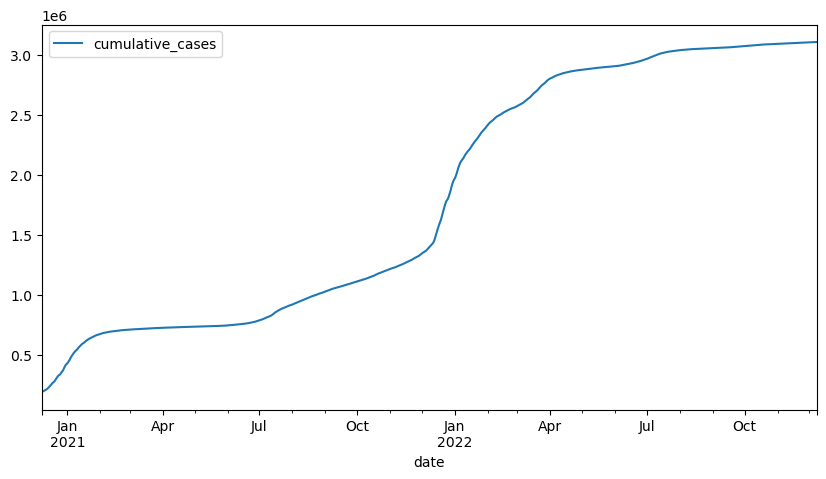

In [119]:
cumulative_cases_in_london = covid_data.loc[covid_data["area"]=="London", ["cumulative_cases", "date"]].plot(x="date", y="cumulative_cases", figsize=(10, 5))
